In [362]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})

# MNIST local update results

Base command (changing k = [1, 4, 10])
```
python cezo_fl_main.py --local-update=4 --dataset=mnist --log-to-tensorboard=True --lr=0.001 --seed=99 --iterations=10000 --num-pert=20 --momentum=0.9 --num-clients=100 --num-sample-clients=10
```

In [378]:
zo_filenames = os.listdir("mnist_zo_fedavg")
fo_filenames = os.listdir("mnist_fo_fedavg")
MODEL_SIZE = 28938

In [399]:
def parse_filename(filename):
    tokens = filename.split("-")
    metadata = {
        tokens[i]: tokens[i+1]
        for i in [2, 4, 6, 8, 10, 12]
    }
    # Cast
    metadata['local_update'] = int(metadata['local_update'])
    metadata['lr'] = float(metadata['lr'])
    metadata['mmtm'] = float(metadata['mmtm'])
    metadata['npert'] = int(metadata['npert'])
    metadata['rge'] = str(metadata['rge'])
    metadata['seed'] = int(metadata['seed'])
    metadata['model'] = tokens[14]
    metadata['type'] = "accuracy" if "Accuracy" in filename else "loss"
    return metadata


def parse_fo_filename(filename):
    tokens = filename.split(",")
    metadata = {
        tokens[i].split("=")[0]: tokens[i].split("=")[1]
        for i in [1,2,3,4]
    }
    # Cast
    metadata['local_update'] = int(metadata['local_update'])
    return metadata

In [431]:
# Load ZO dataset
df_list = []
metadata_list = []
for filename in sorted(zo_filenames):
    metadata = parse_filename(filename)
    if metadata['type'] != "accuracy":
        continue
    if metadata['lr'] != 0.001:
        continue
    df_list.append(pd.read_csv(f"mnist_zo_fedavg/{filename}"))
    metadata_list.append(metadata)
    
# Load FO dataset
df_fo_list = []
metadata_fo_list = []
for filename in ['run-fedavg,local_update=4,nc=100,rounds=1000,lr=0.1,seed=99-tag-Accuracy_test.csv',
                 'run-fedavg,local_update=10,nc=100,rounds=1000,lr=0.1,seed=365-tag-Accuracy_test.csv']:
    df_fo_list.append(pd.read_csv(f"mnist_fo_fedavg/{filename}"))
    metadata_fo_list.append(parse_fo_filename(filename))

In [434]:
def plot_between(x, y_list, local_update, marker):
    y_mean = np.mean(y_list, axis=0)
    y_std = np.std(y_list, axis=0)
    plt.plot(x, y_mean, label=f"{local_update=} FedDisco(mean)", marker=marker, markevery=8, markersize=7)
    plt.fill_between(x, y_mean-1.28* y_std, y_mean+1.28* y_std, alpha=0.4,label=f"{local_update=} FedDisco(std)")

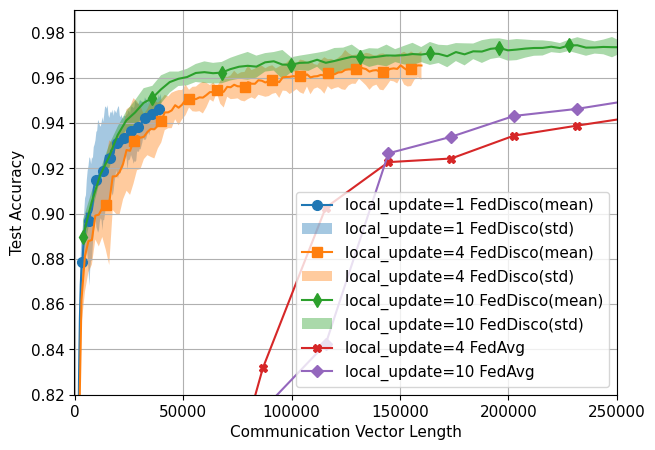

In [435]:
plt.figure(figsize=(7, 5))
max_iter = 2000
markers = "osdXDHh*xPp12348<>"
# Plot ZO
for i,  local_update in enumerate([1, 4, 10]):
    y_list = []
    for df, metadata in zip(df_list, metadata_list):
        if metadata['local_update'] != local_update:
            continue
        _df = df.query(f"Step <= {max_iter}")
        x = _df['Step'] * metadata['local_update'] * metadata['npert']
        y_list.append(_df['Value'])
    # print(y_list, flush=True)
    plot_between(x, y_list, local_update=local_update, marker=markers[i])

i=3
# Plot FO
for df, metadata in zip(df_fo_list, metadata_fo_list):
    local_update=metadata['local_update']
    plt.plot(df['Step']*MODEL_SIZE, df['Value'], label=f"{local_update=} FedAvg", marker=markers[i])
    i+=1

plt.ylim(0.82, 0.99)
plt.xlim(-200, 250000)
plt.grid(True)
plt.xlabel("Communication Vector Length")
plt.ylabel("Test Accuracy")
plt.legend()
plt.show()

## MNIST with perturbation

Base command (changing num-pert from [10, 20, 40])
```
python cezo_fl_main.py --local-update=4 --dataset=mnist --log-to-tensorboard=True --lr=0.0005 --seed=99 --iterations=10000 --num-pert=40 --momentum=0.9 --num-clients=100 --num-sample-clients=10
```

In [438]:
# Load ZO dataset
zo_filenames = os.listdir("mnist_zo_fedavg")

df_list = []
metadata_list = []
for filename in sorted(zo_filenames):
    if "lr-0.0005" not in filename:
        continue
    df_list.append(pd.read_csv(f"mnist_zo_fedavg/{filename}"))
    metadata = parse_filename(filename)
    metadata['type'] = "accuracy" if "Accuracy" in filename else "loss"
    metadata_list.append(metadata)

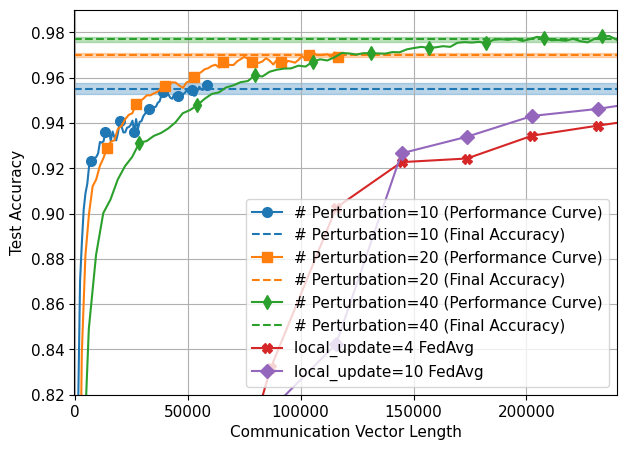

In [440]:
plt.figure(figsize=(7, 5))
i = 0 # for color
xmin = -200
xmax = 240000
for df, metadata in zip(df_list, metadata_list):
    if metadata['type'] != "accuracy":
        continue
    npert=metadata['npert']
    _df = df.query(f"Step <= {1500}")
    plt.plot(_df['Step'] * metadata["local_update"] * metadata["npert"], 
             _df['Value'], label=f"# Perturbation={npert} (Performance Curve)",
             markevery=8, markersize=7, color=f"C{i}", marker=markers[i])
    y_list = list(_df['Value'])[-10:]
    y_mean = np.mean(y_list)
    y_std = np.std(y_list)
    plt.plot([xmin, xmax], [y_mean, y_mean], '--', color=f"C{i}", label=f"# Perturbation={npert} (Final Accuracy)")
    plt.fill_between([xmin, xmax], [y_mean-1.28*y_std, y_mean-1.28*y_std],
                     [y_mean+1.28*y_std, y_mean+1.28*y_std], alpha=0.3, color=f"C{i}")
    i+=1

# Plot FO
for df, metadata in zip(df_fo_list, metadata_fo_list):
    local_update=metadata['local_update']
    plt.plot(df['Step']*MODEL_SIZE, df['Value'], label=f"{local_update=} FedAvg", color=f'C{i}', marker=markers[i],
             markersize=7)
    i+=1

plt.xlabel("Communication Vector Length")
plt.ylabel("Test Accuracy")
plt.ylim(0.82, 0.99)
plt.xlim(xmin, xmax)
plt.grid(True)


plt.legend()
plt.show()

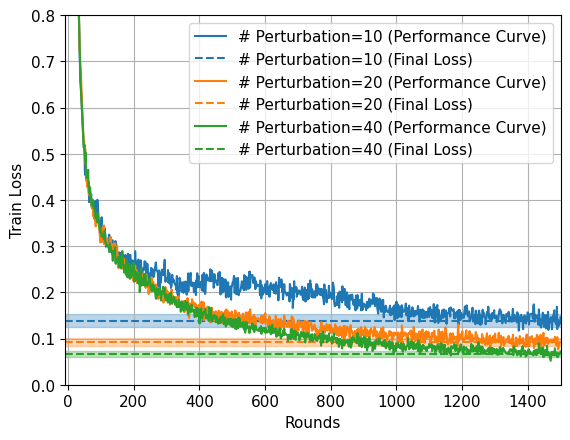

In [371]:
i = 0
xmin, xmax = -10, 1500
for df, metadata in zip(df_list, metadata_list):
    if metadata['type'] != "loss":
        continue
    npert=metadata['npert']
    _df = df.query(f"Step <= {1500}")
    plt.plot(_df['Step'],  _df['Value'], '-', color=f"C{i}", label=f"# Perturbation={npert} (Performance Curve)")
    y_list = list(_df['Value'])[-20:]
    y_mean = np.mean(y_list)
    y_std = np.std(y_list)
    plt.plot([xmin, xmax], [y_mean, y_mean], '--', color=f"C{i}", label=f"# Perturbation={npert} (Final Loss)")
    plt.fill_between([xmin, xmax], [y_mean-1.28*y_std, y_mean-1.28*y_std],
                     [y_mean+1.28*y_std, y_mean+1.28*y_std], alpha=0.3, color=f"C{i}")
    i+=1
    
plt.ylim(-0.0, 0.8)
plt.xlim(xmin, xmax)
plt.xlabel("Rounds")
plt.ylabel("Train Loss")
plt.grid(True)
plt.legend()
plt.show()

# Fashion

In [460]:
FASHION_MODEL_SIZE = 1206590

In [598]:
def comm_step_function(step, npert=25):
    lu = 5
    pert_double_ite = [500, 1000, 2000]
    client_factor = 5
    total_comm = [500 * lu * npert * client_factor]
    total_comm += [total_comm[-1] + 500 * lu * npert * 2 * client_factor]
    total_comm += [total_comm[-1] + 1000 * lu * npert * 4 * client_factor]
    if step < 500:
        return step * lu * npert * client_factor
    elif step < 1000:
        return total_comm[0] + (step - 500) * lu * npert * 2 * client_factor
    elif step < 2000:
        return total_comm[1] + (step - 1000) * lu * npert * 4 * client_factor
    else:
        return total_comm[2] + (step - 2000) * lu * npert * 8 * client_factor

In [662]:
# Load FO
df_fo_list = []
metadata_fo_list = []
for filename in ['run-fashion,fedavg,local_update=5,nc=100,rounds=1000,lr=0.001,seed=42-tag-Accuracy_test.csv']:
    df_fo_list.append(pd.read_csv(f"fashion_fo_fedavg/{filename}"))
    metadata_fo_list.append(parse_fo_filename(filename.replace(",fedavg", "")))

# Load ZO
df_zo_list = []
metadata_zo_list = []
for filename in ['run-fashion-local_update-5-lr-0.0005-mmtm-0.8-npert-25-rge-central-seed-4242-CNN_FMNIST-2024-5-17-12-45-13-tag-Accuracy_test.csv']:
    df_zo_list.append(pd.read_csv(f"fashion_zo_fedavg/{filename}"))
    metadata_zo_list.append(parse_filename(filename))

df_top_k = pd.read_csv("fashion_fo_fedavg/run-fashion,fedavg,local_update=5,nc=100,rounds=1000,lr=0.001,seed=701,topk=0.1-tag-Accuracy_test.csv")
df_fedcom = pd.read_csv("fashion_fo_fedavg/run-fashion,fedavg,local_update=5,nc=100,rounds=1000,lr=0.001,seed=705,quan-tag-Accuracy_test.csv")

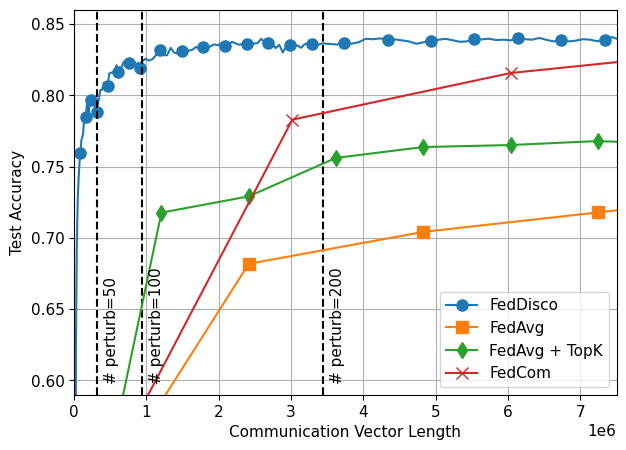

In [665]:
max_iter = 3000
plt.figure(figsize=(7, 5))

for df, metadata in zip(df_zo_list, metadata_zo_list):
    _df = df.query(f"Step <= {max_iter}")
    plt.plot(_df['Step'].map(comm_step_function), _df['Value'], '-o', markevery=6, label="FedDisco", markersize=8)

plt.axvline(comm_step_function(500), color="black", linestyle="--")
plt.text(comm_step_function(500)+ 1e5, 0.6,'# perturb=50', rotation=90)
plt.axvline(comm_step_function(1000), color="black", linestyle="--")
plt.text(comm_step_function(1000)+1e5, 0.6, '# perturb=100', rotation=90)
plt.axvline(comm_step_function(2000), color="black", linestyle="--")
plt.text(comm_step_function(2000)+1e5, 0.6, '# perturb=200', rotation=90)

for df in df_fo_list:
    _df = df.query(f"Step <= {max_iter}")
    plt.plot(_df['Step']*FASHION_MODEL_SIZE*2, _df['Value'], '-s', label="FedAvg", markersize=8)

_df = df_top_k.query(f"Step <= {max_iter}")
plt.plot(_df['Step']*FASHION_MODEL_SIZE*0.1, _df['Value'], '-d', label="FedAvg + TopK", markersize=8)

_df = df_fedcom.query(f"Step <= {max_iter}")
plt.plot(_df['Step']*FASHION_MODEL_SIZE*0.25, _df['Value'], '-x', label="FedCom", markersize=8)


plt.xlim(0, 75e5)
plt.ylim(0.59, 0.86)
plt.xlabel("Communication Vector Length")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [673]:
# Load ZO
df_zo_list = []
metadata_zo_list = []
for filename in ['run-fashion-local_update-5-lr-0.0005-mmtm-0.8-npert-25-rge-central-seed-4242-CNN_FMNIST-2024-5-17-12-45-13-tag-Loss_train.csv']:
    df_zo_list.append(pd.read_csv(f"fashion_zo_fedavg/{filename}"))
    metadata_zo_list.append(parse_filename(filename))

df_fed_avg = pd.read_csv("fashion_fo_fedavg/run-fashion,fedavg,local_update=5,nc=100,rounds=1000,lr=0.001,seed=42-tag-Loss_train.csv")
df_top_k = pd.read_csv("fashion_fo_fedavg/run-fashion,fedavg,local_update=5,nc=100,rounds=1000,lr=0.001,seed=701,topk=0.1-tag-Loss_train.csv")
df_fedcom = pd.read_csv("fashion_fo_fedavg/run-fashion,fedavg,local_update=5,nc=100,rounds=1000,lr=0.001,seed=705,quan-tag-Loss_train.csv")

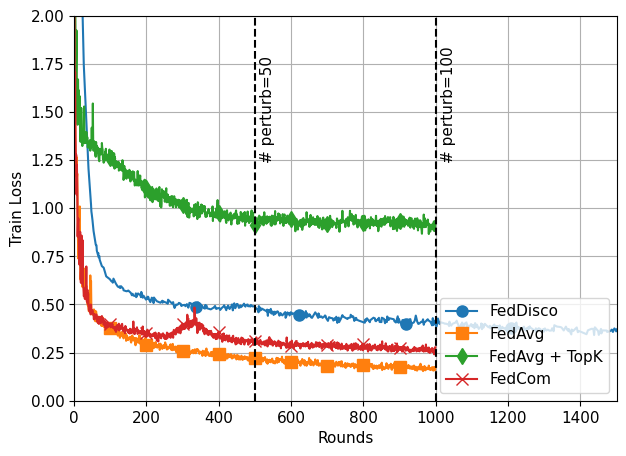

In [678]:
plt.figure(figsize=(7, 5))
max_iter = 3000

for df, metadata in zip(df_zo_list, metadata_zo_list):
    _df = df.query(f"Step <= {max_iter}")
    plt.plot(_df['Step'], _df['Value'] * 0.9, '-o', label="FedDisco", markevery=100, markersize=8)

_df = df_fed_avg.query(f"Step <= {max_iter}")
plt.plot(_df['Step'], _df['Value'],  '-s', label="FedAvg", markevery=100, markersize=8)

_df = df_top_k.query(f"Step <= {max_iter}")
plt.plot(_df['Step'], _df['Value'], '-d', label="FedAvg + TopK", markevery=100, markersize=8)

_df = df_fedcom.query(f"Step <= {max_iter}")
plt.plot(_df['Step'], _df['Value'], '-x', label="FedCom", markevery=100, markersize=8)
    
    
plt.axvline(500, color="black", linestyle="--")
plt.text(515, 1.25,'# perturb=50', rotation=90)
plt.axvline(1000, color="black", linestyle="--")
plt.text(1015, 1.25,'# perturb=100', rotation=90)

plt.xlim(0, 1500)
plt.ylim(0.0, 2)
plt.xlabel("Rounds")
plt.ylabel("Train Loss")
plt.grid(True)
plt.legend(loc=4)
plt.show()